In [232]:
import pandas as pd

data = pd.read_csv('../db/dataset_tissue.txt', sep=',',header=0, index_col=0)

labels = pd.read_csv('../db/clase.txt', sep=',',header=0, index_col=0)


print(labels)
print(data)

            x
1      kidney
2      kidney
3      kidney
4      kidney
5      kidney
..        ...
185  placenta
186  placenta
187  placenta
188  placenta
189  placenta

[189 rows x 1 columns]
            GSM11805.CEL.gz  GSM11814.CEL.gz  GSM11823.CEL.gz  \
1007_s_at         10.191267        10.509167        10.272027   
1053_at            6.040463         6.696075         6.144663   
117_at             7.447409         7.775354         7.696235   
121_at            12.025042        12.007817        11.633279   
1255_g_at          5.269269         5.180389         5.301714   
...                     ...              ...              ...   
91703_at           6.434851         7.676989         6.424996   
91816_f_at         5.700448         6.566479         5.641277   
91826_at           9.211163         9.415980         8.192909   
91920_at           8.339130         8.214426         8.456095   
91952_at           7.367797         7.917754         7.598461   

            GSM11830.CEL.gz

In [233]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Cargar dataset_tissue.txt
data_path = '../db/dataset_tissue.txt'
data = pd.read_csv(data_path, sep=',', header=0, index_col=0)

# Cargar clase.txt
classes_path = '../db/clase.txt'
classes = pd.read_csv(classes_path, sep=',', header=0, index_col=0)

# Transponer los datos
data_transposed = data.transpose()

# Normalizar los datos usando MinMaxScaler
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data_transposed),
                               columns=data_transposed.columns,
                               index=data_transposed.index)

# Aplicar PCA para retener el 95% de la varianza
pca_95 = PCA(n_components=0.95)
data_pca = pca_95.fit_transform(data_normalized)

print('Número de componentes principales: ', pca_95.n_components_)

Número de componentes principales:  101


In [235]:
import numpy as np
from scipy.stats import multivariate_normal
import sklearn

covariances = [np.eye(data_pca.shape[1]) for _ in range(pca_95.n_components_)]

#realizamos una limpieza exaustiva debido a errores presenados durante la copilacion

def clean_covariances(covariances, epsilon=1e-6):
    cleaned_covariances = covariances.copy()
    for i in range(len(covariances)):
        if np.any(np.isnan(covariances[i])) or np.any(np.isinf(covariances[i])):
            # Si algún valor en covariances[i] es NaN o inf, reemplaza toda la matriz por la matriz de identidad
            cleaned_covariances[i] = np.eye(covariances[i].shape[0]) * epsilon
    return cleaned_covariances

# Limpia las covarianzas
cleaned_covariances = clean_covariances(covariances)
means = data_pca[np.random.choice(data_pca.shape[0], pca_95.n_components_, replace=False), :]

def clean_means(means, epsilon=1e-6):
    cleaned_means = means.copy()
    for i in range(len(means)):
        if np.any(np.isnan(means[i])) or np.any(np.isinf(means[i])):
            # Si algún valor en means[i] es NaN o inf, reemplázalo por un pequeño valor epsilon
            cleaned_means[i] = np.ones_like(means[i]) * epsilon
    return cleaned_means
cleaned_means = clean_means(means)

# Coeficientes de mezcla
mixing_coeffs = np.ones(pca_95.n_components_ )/ pca_95.n_components_

def clean_mixing_coeffs(mixing_coeffs, epsilon=1e-6):
    cleaned_mixing_coeffs = mixing_coeffs.copy()
    if np.any(np.isnan(mixing_coeffs)) or np.any(np.isinf(mixing_coeffs)):
        # Si algún valor en mixing_coeffs es NaN o inf, reemplázalo por un valor uniforme
        cleaned_mixing_coeffs = np.ones_like(mixing_coeffs) / len(mixing_coeffs)
    return cleaned_mixing_coeffs
cleaned_mixing_coeffs = clean_mixing_coeffs(mixing_coeffs)

print("\nCleaned Covariances:\n", cleaned_covariances)




Cleaned Covariances:
 [array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]]), array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]]), array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]]), array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]]), array([[

In [237]:
explained_variance = np.var(data_pca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
explained_variance_ratio_cumsum = np.cumsum(explained_variance_ratio)
num_components_95 = np.argmax(explained_variance_ratio_cumsum >= 0.95) + 1
print(f"Número de componentes para obtener el 95% de la varianza: {num_components_95}")

Número de componentes para obtener el 95% de la varianza: 63


In [238]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import homogeneity_score, completeness_score,silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

class GMM:
    def __init__(self, num_components=2, max_iters=100, tol=1e-4):
        self.num_components = num_components
        self.max_iters = max_iters
        self.tol = tol

    def e_step(self, X, means, covariances, mixing_coeffs):
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.num_components))

        for i in range(self.num_components):
            try:
                responsibilities[:, i] = cleaned_mixing_coeffs[i] * multivariate_normal.pdf(X, mean=cleaned_means[i], cov=cleaned_covariances[i])
            except np.linalg.LinAlgError:
                # En caso de que ocurra un error de álgebra lineal, como una matriz de covarianza singular, asigna una pequeña covarianza
                covariances[i] = np.eye(X.shape[1]) * 1e-6
                responsibilities[:, i] = cleaned_mixing_coeffs[i] * multivariate_normal.pdf(X, mean=cleaned_means[i], cov=cleaned_covariances[i])

        
        return responsibilities

    def m_step(self, X, responsibilities, epsilon=1e-6):
        n_samples, n_features = X.shape

        means_new = np.zeros((self.num_components, n_features))
        covariances_new = np.zeros((self.num_components, n_features, n_features))
        mixing_coeffs_new = np.zeros(self.num_components)

        for i in range(self.num_components):
            weights = responsibilities[:, i]
            total_weight = weights.sum()
            means_new[i] = np.dot(weights, X) / total_weight

            covariances_new[i] = np.dot(weights * (X - means_new[i]).T, X - means_new[i]) / total_weight + epsilon * np.eye(n_features)

            mixing_coeffs_new[i] = total_weight / n_samples

        return means_new, covariances_new, mixing_coeffs_new

    def fit(self, X, means, covariances, mixing_coeffs):
        for _ in range(self.max_iters):
            responsibilities = self.e_step(X, means, covariances, mixing_coeffs)
            means, covariances, mixing_coeffs = self.m_step(X, responsibilities)

        return means, covariances, mixing_coeffs
    #asignamos el cluster dentro de la clase gmm
    def assign_clusters(self, X, means, covariances, mixing_coeffs):
        # Paso E
        responsibilities = self.e_step(X, means, covariances, mixing_coeffs)
        
        # Asigna cada punto de datos al componente con la responsabilidad máxima
        clusters = np.argmax(responsibilities, axis=1)
        
        return clusters
    
# Uso de la clase GMM
gmm = GMM(num_components=num_components_95)
means_final, covariances_final, mixing_coeffs_final = gmm.fit(data_pca, means, covariances, mixing_coeffs)
clusters = gmm.assign_clusters(data_pca, means_final, covariances_final, mixing_coeffs_final)
homogeneity = homogeneity_score(labels.values.ravel(), clusters)
completeness = completeness_score(labels.values.ravel(), clusters)
silhouette = silhouette_score(data_pca, clusters)
davies_bouldin = davies_bouldin_score(data_pca, clusters)
print(f"Resultados:\nHomogeneity: {homogeneity:.2f}\nCompleteness: {completeness:.2f}\nSilhouette Score: {silhouette:.2f}\nDavies-Bouldin Index: {davies_bouldin:.2f}")

Resultados:
Homogeneity: 0.98
Completeness: 0.46
Silhouette Score: 0.07
Davies-Bouldin Index: 1.34


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


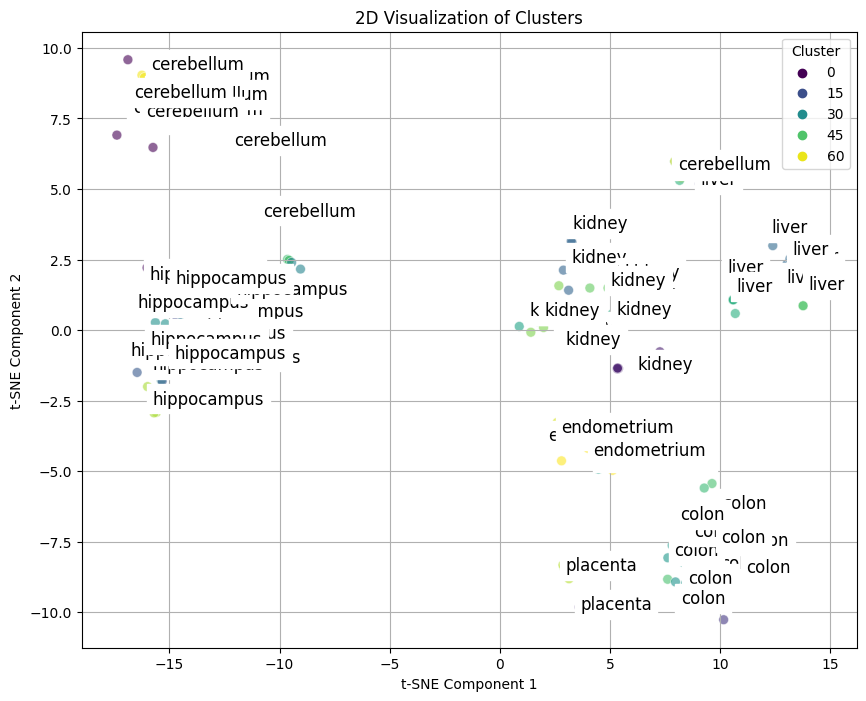

In [250]:
# Paso 3: Visualización
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(data_pca)

# Analizar la composición de cada cluster y encontrar el tipo de tejido más común
most_common_labels = []
for cluster_id in range(num_components_95):  # Asegúrate de que k es el número de clusters que has utilizado
    # Extraer las etiquetas verdaderas de los puntos en este cluster
    cluster_labels = classes.values.ravel()[clusters == cluster_id]

    # Encontrar y guardar la etiqueta más común
    most_common = Counter(cluster_labels).most_common(1)[0][0]
    most_common_labels.append(most_common)

# Visualización
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=clusters, palette="viridis", s=50, alpha=0.6)
plt.title('2D clustering')

# Etiquetar cada cluster con el tipo de tejido más común
for i, label in enumerate(most_common_labels):
    # Calcular el centroide del cluster para colocar la etiqueta
    cluster_center = X_tsne[clusters == i, :].mean(axis=0)
    plt.text(cluster_center[0], cluster_center[1], str(label), fontsize=12, backgroundcolor='white')

plt.xlabel(' Component 1')
plt.ylabel(' Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.show()
